Import required modules

In [8]:
from datetime import datetime
import helper as hp
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Set Required Base Path (*Note*: relative paths or $Home (~) directory not working)

In [9]:
hp.FIRED_BASE_FOLDER = "<Set directory of FIRED>"

startDate = "2020.06.13" # None to select dataset first day
stopDate = "2020.07.16" # None to select dataset last day (timepoint) 

# Get recording range from files and args 
start, end = hp.getRecordingRange(startDate, stopDate)
measure = "p" # p,q,s
smoothing = 3

Select some appliances you are interested in

In [10]:
includeAppliances = ["kettle", "espresso machine", "stove", "television", "office pc", "router #1", "hairdryer"]

# Get list of all appliances in dataset
appliances = hp.getApplianceList()
# If specific appliances should be selected, based on script arguments
if len(includeAppliances) > 0: appliances = [a for a in includeAppliances if a in appliances]

print(appliances)

['kettle', 'espresso machine', 'television', 'office pc', 'router #1', 'hairdryer']


Load 1 Hz data of these appliances

In [17]:
# Load power of these appliances from 1Hz file (should be sufficient for histogram)
powers = [hp.getPower(a, 1, startTs=start, stopTs=end) for a in appliances]

# Remove power which could not be extracted
for p,a in zip(powers, appliances): 
    if p is None: print("Could not extract power of appliance: " + str(a))
powers = [p for p in powers if p is not None]

Power histogram (distributuon of amount of power drawn by device). 
The OFF state is removed from the data by defining a threshold. Bin size represents the number of bins used for
the histogram plotted. The more bins, the smoother the histogram. 

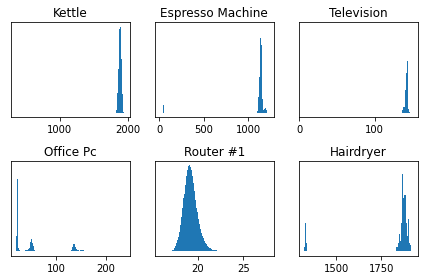

In [18]:
off_threshold = 5.0
binsize = 200

# Calculate X,Y subplot grid
subplotsX = min(3, int(len(powers)))
subplotsY = max(1, int(len(powers)/3) + 1)
if len(powers)%3 == 0: subplotsY -= 1

# Init figure
fig, axes = plt.subplots(subplotsY,subplotsX, tight_layout=True)
# Flatten axis list
if subplotsY > 1: axes = [a for ax in axes for a in ax]

# Add data to each figure
for axis, power in zip(axes, powers):
    axis.set_title(hp.prettyfyApplianceName(power["name"]))
    data = power["data"][measure]
    if smoothing > 1:
        data = np.median(data[0:int(len(data)/smoothing)*smoothing].reshape(-1, smoothing), axis=1) 

    data = data[data > off_threshold]
    hist, bins = np.histogram(data, binsize)
    # thres = 0.0005*np.sum(hist)
    # hist[hist < thres] = 0
    # width = 1.0 * (bins[1] - bins[0])
    # maxV = max([v for v,h in zip(bins,hist) if h > 0])
    # minV = min([v for v,h in zip(bins,hist) if h > 0]) - width
    center = (bins[:-1] + bins[1:]) * 0.5
    axis.fill_between(center, hist, step="pre")
    # axis.set_xlim([minV, maxV])
    #axis.step(center, hist, align="center", width=width)
    #axis.hist(data, bins=binsize) #, histtype="stepfilled")
    axis.set_yticks([])
# Delete unused grid axes
for ax in axes[len(powers):]: fig.delaxes(ax)

Distribution of usage over time.

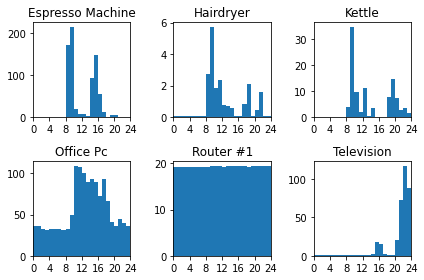

In [13]:
# Init figure
fig, axes = plt.subplots(subplotsY, subplotsX, tight_layout=True)
# Flatten axis list
if subplotsY > 1: axes = [a for ax in axes for a in ax]
startDate = datetime.fromtimestamp(start)
startDay = startDate.replace(hour=0, minute=0, second=0, microsecond=0)
if startDate != startDay: startDay = startDay + timedelta(days=1)

stopDay = datetime.fromtimestamp(end).replace(hour=0, minute=0, second=0, microsecond=0)
sampleStart = int(startDay.timestamp()-start)
sampleStop = int(stopDay.timestamp()-start)

# Add data to each figure
for axis, power in zip(axes, powers):
    axis.set_title(hp.prettyfyApplianceName(power["name"]))
    data = np.abs(power["data"][measure])[sampleStart:sampleStop]
    # For data with some missing samples or too much samples
    # This can happen for non finished days
    days = int(len(data)/(24*60*60))
    # e = days*(24*60*60)
    # if len(data) > e: data = data[:e]
    # elif len(data) < e: data = npconcatenate(data, np.zeros(e-len(data)))
    # Split data in each day
    data = data.reshape((days, 24, 60*60))

    # mean for each hour
    data = np.mean(data, axis=2)
    # mean for each hour a day
    data = np.mean(data, axis=0)

    axis.bar(np.arange(0, 24, 1), height=data, align='edge', width=1.0)#
    axis.set_xlim(0, 24)
    axis.set_xticks(np.arange(0, 25, 4))

# Delete unused grid axes
for ax in axes[len(powers):]: fig.delaxes(ax)